# CSCN 8010 - Foundations of Machine Learning
# Final Project - Music Genre Classification

### By: Aneesh Ramesh () and Troy Mazerolle (8972394)


## Introduction

For this project, we want to explore how we can classify genres of music.  The challenge is to convert an audio file into a form of data that we know how to work with.

To do this, we will use what are called **spectrograms**.  Spectrograms are a graphical representation of the frequency content of a signal as it evolves over time.  It is a two-dimensional display where time is plotted on the x-axis, frequency on the y-axis, and the color or intensity represents the magnitude or amplitude of the signal's frequency components.  Spectrograms are widely employed in fields like signal processing and acoustics to analyze and visualize audio signals, providing insights into the changing frequencies within a given time frame.  This tool is crucial for tasks such as speech analysis, music processing, and various scientific and engineering applications where understanding the temporal and spectral characteristics of a signal is essential.

This report will provide a walkthrough of our analysis, from loading the data to our accuracy results.  As usual, we start with loading in all our libraries.

In [157]:
# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

# Plotting and Model Evaulation Libraries
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Utility Libraries
import numpy as np
import os

# Setting seed for reproducibility
keras.utils.set_random_seed(42) 

## Data Loading

We now load in the spectrograms from our folder, and split them into training, validation, and test sets.  For the code used to create the spectrograms from the audio files, see Appendix A.

<span style="color:red">I was thinking that your code that produced the images can go at the end of the report, in an appendix section.  I think we can just copy/paste what you write and wrap it in an if False {} statement so that it doesn't run but people/Ran can still read it.</span>

In [158]:
training_images_filepath = "./Data/spec_original"
category_labels = os.listdir(training_images_filepath)

xdim = 180 
ydim = 180

spectograms = image_dataset_from_directory(
    training_images_filepath,
    image_size = (xdim, ydim),
    batch_size = 108)

## Use num_batches - 2 batches for training, 1 batch for validation, 1 batch for testing
num_batches = tf.data.experimental.cardinality(spectograms).numpy()
train = spectograms.take(num_batches - 2).cache()
remaining = spectograms.skip(num_batches - 2)
validation = remaining.take(1).cache()
test = remaining.skip(1).cache()

Found 1080 files belonging to 11 classes.


Before continuing, we can get a sense of what some of our spectrograms look like.  Below we will output the first five spectrograms in the validation set and their corresponding label.

<span style="color:red">If I have time, I would like to improve this part by outputting an example of every class instead of outputting an example of whatever is on top of the validation set.</span>

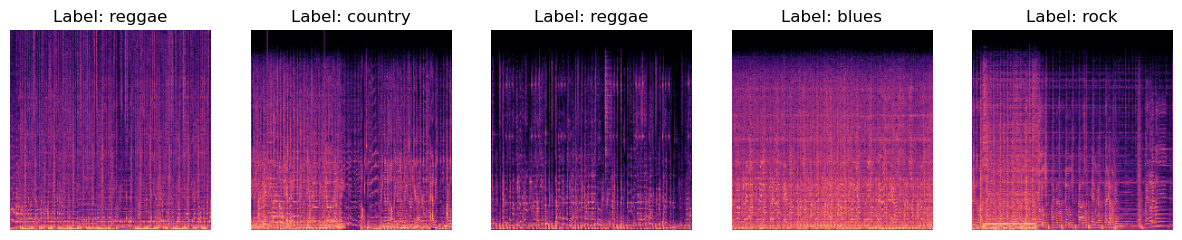

In [159]:
for images, labels in validation:
    plt.figure(figsize=(15, 500))
    for i in range(5):
        plt.subplot(num_rows, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {category_labels[labels[i].numpy()]}")
        plt.axis("off")
    plt.show()

## Model Fine-Tuning

We will now start building the model to classify the spectrograms.  To do this, we will fine-tune the VGG16 model like we did in lab 10.

In [160]:
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False,
    input_shape = (xdim, ydim, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

For the first step of our fine-tuning, we will freeze the base model and add in our own head to train.  We will add two dense layers, each with 256 nodes and a relu activation function.  We will also add a dropout layer that drops 20% of the neurons.  Our output layer will use a softmax activation function with the number of nodes equal to the number of classes we have (in our case, 11).

In [161]:
conv_base.trainable = False

inputs = keras.Input(shape=(xdim, ydim, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(inputs)
x = layers.Flatten()(x)
x = layers.Dense(256, activation = "relu")(x)
x = layers.Dense(256, activation = "relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(category_labels), activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

history = model.fit(
    train,
    epochs = 50,
    validation_data = validation,
    verbose = 0)

Our validation accuracy is pretty solid avter 50 epochs.  We can visualize the training progression below.

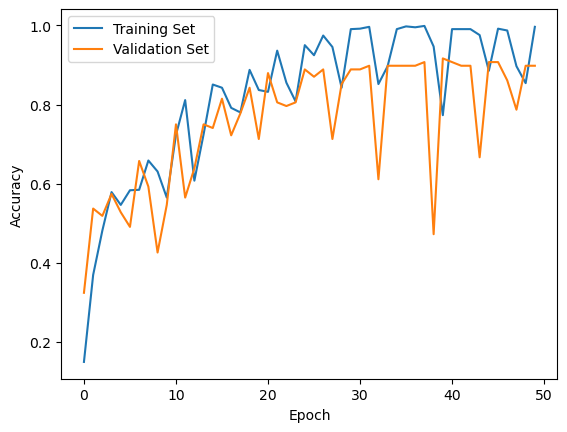

In [162]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training Set", "Validation Set"]);

Now that the head of our model is moderately trained, we can unfreeze the last four layers of the VGG16 model and fine-tune them.

In [163]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

history = model.fit(
    train,
    epochs = 10,
    validation_data = validation,
    verbose = 0)

Fine-tuning in this step does not seem to improve the accuracy of the model further.  Again, we can visualize the training progression below.

<span style="color:red">I might add a third step of fine-tuning where I unfreeze the bottom eight layers of the VGG16 model and fine-tune those.  I don't think it will improve accuracy, but it is a unique step that we didn't do in lab 10.</span>

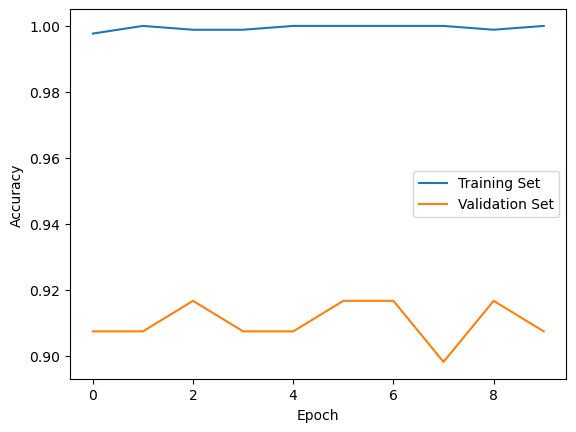

In [164]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training Set", "Validation Set"]);

## Model Evaluation

Now that we have our model, we can test its performance on the test set.

In [165]:
predictions_prob = model.predict(test)
predictions = np.argmax(predictions_prob, axis = 1)

ground_truth = [label for _, label in test.unbatch()]
ground_truth = tf.concat(ground_truth, axis = 0).numpy()  

accuracy = accuracy_score(ground_truth, predictions)
print("Accuracy of the model:", accuracy)

1/1 [==============================] - 2s 2s/step
Accuracy of the model: 0.9259259259259259


We get an accuracy of 92.5%, which is very strong.  We can further analyze the performance by evaluating the confusion matrix.

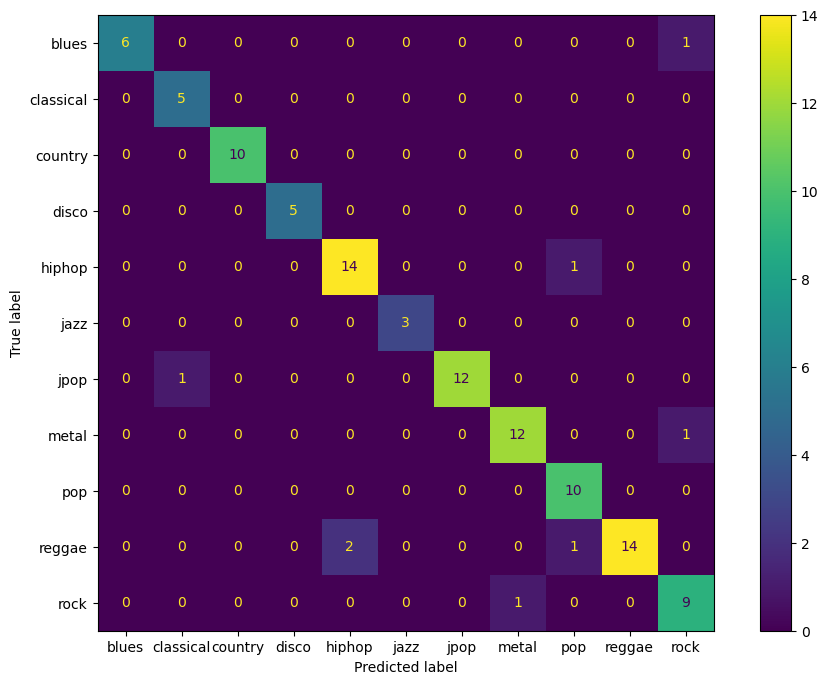

In [166]:
fig, ax = plt.subplots(figsize=(12,8))
conf_matrix = confusion_matrix(ground_truth, predictions)
ConfusionMatrixDisplay(conf_matrix, display_labels = category_labels).plot(ax = ax);

From the confusion matrix we can see that most of our misclassifications are one-off misclassifications.  Most of these misclassifications make sense, such as metal being misclassified as rock or hiphop being misclassified as pop.  One misclassification that stands out is a jpop audio track being misclassified as classical.

<span style="color:red">If I can figure out how to do it, I would love to hear the jpop clip that was misclassed as classical.  Would be good to include the clip in there too.</span>

## Conclusion

Overall, our model performed very well, showing that image classification of spectrographs is a effective way to classify genres of audio files.  This concept can be extended to other forms of audio classification as well, such as voice recognition, identifying animal sounds, diagnosing car problems by the sound they make, etc.

<span style="color:red">I want to add more relevant examples to this list.</span>

## Sources

Audio Data: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

VGG16: https://arxiv.org/abs/1409.1556

## Apendix A: Generating Spectograms from Audio Files

In [167]:
if False:
    None